# Andean Amazon - Watershed extraction and watershed properties

[Emilio Mayorga](https://github.com/emiliom). 2019-3-31. From [WaterHackWeek19](https://waterhackweek.github.io), as part of the [Andean Amazon Hydrology project](https://github.com/waterhackweek/whw2019_AndeanAmazonHydro).

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas as gpd
import geojson

import pysheds
from pysheds.grid import Grid

import rasterstats as rs

Base path directory. Set to your own base path.

In [19]:
base_dpth = "<MY BASE PATH>"

## Extract catchments using `pysheds`
See https://github.com/mdbartos/pysheds/blob/master/examples/quickstart.ipynb

### Read and examine flow direction grid.

In [3]:
grid = Grid.from_raster(os.path.join(base_dpth, 'fd_latlon.tif'), data_name='dir')

In [4]:
#         N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [5]:
# This is probably not used currently. Previously used for the plot colorbar
boundaries = ([0] + sorted(list(dirmap)))
boundaries

[0, 1, 2, 4, 8, 16, 32, 64, 128]

Examine the distribution of unique flow direction values (not required, but helpful).

In [6]:
unique_elements, counts_elements = np.unique(grid.dir, return_counts=True)

In [7]:
print("Frequency of unique values of the flowdir array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the flowdir array:
[[   -32768        -1         0         1         2         4         8
         16        32        64       128]
 [160240443      1388    350002  13820696   8319748  14214943   7462776
   13997327   7776760  14804935   8476582]]


### Extract catchment

In [8]:
# site_lon, site_lat = -71.96827,-3.42253
# site_lon, site_lat = -72.01033, -3.45204

#   successful, in amazon
# site_lon, site_lat = -78.49802,-1.34768
#site_lon, site_lat = -78.05721,-1.54698
#site_lon, site_lat = -75.19384,-4.28950
site_lon, site_lat = -78.31892,-4.84790

# not successful (large watersheds)
#site_lon, site_lat = -77.86862,-1.78537
#site_lon, site_lat = -76.59389,-4.45213
#site_lon, site_lat = -75.70195,-5.02355

#site_lon, site_lat = -78.9533333, -0.314166667 # successful, pacific

In [9]:
def catchment_delineate(dirgrid, dirdata_name, dirmap, x, y, catchment_name='catch', recursionlimit=15000):
    # Delineate the catchment
    # From pysheds example: recursionlimit=15000
    dirgrid.catchment(data=dirdata_name, dirmap=dirmap, 
                      x=x, y=y, xytype='label', 
                      out_name=catchment_name, nodata_out=0,
                      recursionlimit=20000000)
    
    # Clip the bounding box to the catchment
    dirgrid.clip_to(catchment_name)
    
    # Get a view of the catchment
    catchment_gridview = dirgrid.view(catchment_name, nodata=np.nan)
    
    # Polygonize catchment grid
    shapes = dirgrid.polygonize()  # shapes is a "generator"
    geojsondct = [shp for shp in shapes][0][0]
    geoj = geojson.Feature(geometry=geojson.Polygon(geojsondct['coordinates']))
    catchment_gdf = gpd.GeoDataFrame.from_features([geoj])
    
    return catchment_gridview, catchment_gdf

In [10]:
# For examining and setting the Python recursion limit (for larger catchments)
# sys.getrecursionlimit()
# sys.setrecursionlimit(1500)

In [11]:
catch, catch_gdf = catchment_delineate(grid, 'dir', dirmap, site_lon, site_lat, 
                                       catchment_name='catch', recursionlimit=1500)

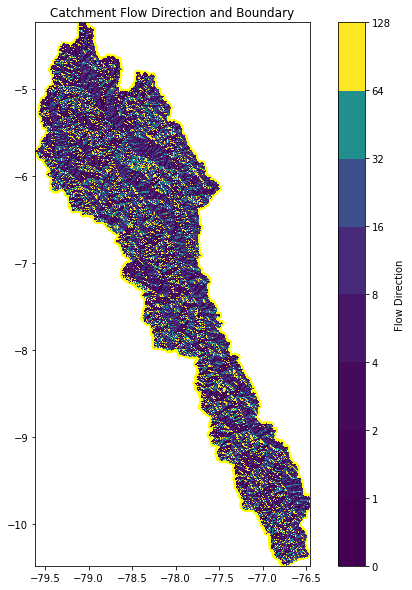

In [12]:
# Plot the delineated catchment flow direction grid and polygonized catchment boundary
fig, ax = plt.subplots(1, figsize=(10, 10))

im = ax.imshow(catch, extent=grid.extent, zorder=1, cmap='viridis')
plt.colorbar(im, ax=ax, boundaries=boundaries, values=sorted(dirmap), 
             label='Flow Direction')
# Polygonized catchment boundary is shown in yellow
catch_gdf.plot(ax=ax, facecolor='None', edgecolor='yellow', linewidth=4)
plt.title('Catchment Flow Direction and Boundary');

### Create flow accumulation, then plot it
We don't actually use it, but it's helpful as verification.

In [13]:
grid.accumulation(data='catch', dirmap=dirmap, out_name='acc')

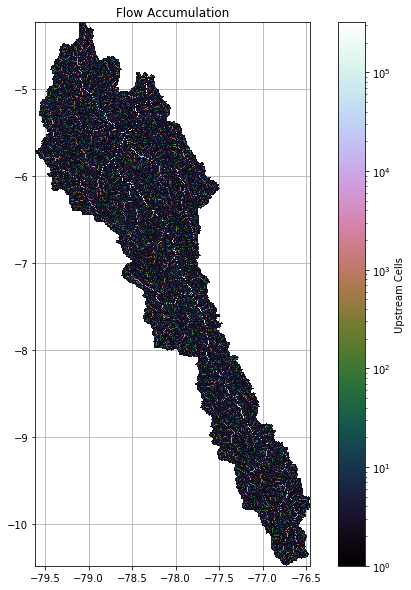

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid('on', zorder=0)
acc_img = np.where(grid.mask, grid.acc + 1, np.nan)
im = ax.imshow(acc_img, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc.max()))
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation');

## Calculate mean elevation over the catchment polygon and watershed area
Uses [rasterstats](https://github.com/perrygeo/python-rasterstats) package

In [15]:
dem_elev_pth = os.path.join(base_dpth, "sa_dem_15s/sa_dem_15s/hdr.adf")

In [16]:
catch_elev_cellcount = rs.zonal_stats(catch_gdf, dem_elev_pth, prefix='elev_m_', 
                                      all_touched=True, stats=['mean', 'count'],
                                      geojson_out=False)

Other statistics could be requested, too, including min, max, stddev, 

In [17]:
catch_elev_cellcount

[{'elev_m_mean': 2633.5268115986632, 'elev_m_count': 324934}]

Use simple, constant factor to convert from cell counts (with cells in square degrees) to km2.
- 1 cell length = 15 arc seconds
- 1 degree = 3600 arc seconds
- 1 degree = 110 km ((approximately, at the equator)

In [18]:
catch_area_km2 = catch_elev_cellcount[0]['elev_m_count'] * ((15/1)*(1/3600)*(110/1))**2
catch_area_km2

68258.70486111111